<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_amalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! gdown --id 1FkB-wMHYzgK74-pek2H33DIpmfSOIxWc  # copy this line for peru data
! unzip Insoluables_TrainingData26May2022.zip
! unzip Peru_data.zip                           # copy this line for peru data
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
 extracting: images/QCY/QCY_27_2_5_253.png  
 extracting: images/QCY/QCY_27_2_5_254.png  
 extracting: images/QCY/QCY_27_2_5_255.png  
 extracting: images/QCY/QCY_27_2_5_256.png  
 extracting: images/QCY/QCY_27_2_5_257.png  
 extracting: images/QCY/QCY_27_2_5_258.png  
  inflating: images/QCY/QCY_27_2_5_259.png  
 extracting: images/QCY/QCY_27_2_5_26.png  
 extracting: images/QCY/QCY_27_2_5_260.png  
 extracting: images/QCY/QCY_27_2_5_261.png  
  inflating: images/QCY/QCY_27_2_5_262.png  
 extracting: images/QCY/QCY_27_2_5_263.png  
 extracting: images/QCY/QCY_27_2_5_264.png  
  inflating: images/QCY/QCY_27_2_5_265.png  
  inflating: images/QCY/QCY_27_2_5_266.png  
 extracting: images/QCY/QCY_27_2_5_267.png  
 extracting: images/QCY/QCY_27_2_5_268.png  
 extracting: images/QCY/QCY_27_2_5_269.png  
 extracting: images/QCY/QCY_27_2_5_27.png  
  inflating: images/QCY/QCY_27_2_5_270.png  
 extracting: images/QCY/QCY_27_2_5_271.pn

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb


# Standard packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Package for splitting data
from sklearn.model_selection import train_test_split

# PyTorch packages for ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam
!pip install torchinfo
from torchinfo import summary
import torchvision.models as models

# Package for confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from PIL import Image
from torchvision import transforms
# Helper functions
#from HelperFunctions import ParticleDataset, plot_confusion_matrix 
cols_mva = ['Area (ABD)', 'Area (Filled)', 'Aspect Ratio', 'Biovolume (Cylinder)',
       'Biovolume (P. Spheroid)', 'Circle Fit',
       'Circularity', 'Circularity (Hu)', 'Compactness', 'Convex Perimeter',
       'Convexity', 'Diameter (ABD)', 'Diameter (ESD)', 'Edge Gradient',
       'Elongation', 'Feret Angle Max', 'Feret Angle Min', 'Fiber Curl',
       'Fiber Straightness', 'Geodesic Aspect Ratio', 'Geodesic Length',
       'Geodesic Thickness', 'Intensity', 'Length', 'Particles Per Chain',
       'Perimeter', 'Roughness', 'Sigma Intensity', 'Sum Intensity',
       'Symmetry', 'Transparency', 'Volume (ABD)', 'Volume (ESD)', 'Width']
class ParticleDataset():
    # This class is simply a "list-like" object
    # that will load an image on the fly (using Image.open).
    
    def __init__(self, df):
        self.df = df
        self.imgpaths = df['imgpaths'].to_numpy()
        # self.imgpaths = df[path+'train/'].to_numpy()
        self.labels = df['class'].to_numpy()
        scaler = StandardScaler()
        self.X_features = scaler.fit_transform(df[cols_mva])
        
        # Feel free to change these transforms! They are not optimal.
        # You could also include e.g. RandomHorizontalFlip, RandomVerticalFlip
        # for data augmentation.
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[94/255], std=[12/255]),
            ])

    def __len__(self):
        return len(self.df)   # you can limit the number of images by returning a smaller number here

    def __getitem__(self, idx):
        imgpath = self.imgpaths[idx]
        image = Image.open(imgpath)
        image = image.convert('RGB')
        image = self.transform(image)        
        
        label = torch.tensor(self.labels[idx]).float()
        xfeatures = torch.from_numpy(self.X_features[idx]).float()
        
        return image, label, xfeatures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# copy this cell for peru data
peru_path = '/content/QCY.csv'
peru_im_path = '/content/images/QCY/'
peru_df = pd.read_csv(peru_path)
#peru = not_training_set(peru_df, peru_im_path)

In [59]:
#im, feat = peru.__getitem__(10)

In [66]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
train_df = pd.read_csv(sup_path+'train.csv')
#train_df = training_set(sup_df, sup_im_path)
#train_df['imgpaths']
train_df['imgpaths']

from tqdm import tqdm

class_temp = []
for i in tqdm(range(len(train_df))):
  if train_df.iloc[i]['camp'] == 1:
    class_temp.append(0)
  elif train_df.iloc[i]['corylus'] == 1:
    class_temp.append(1)
  elif train_df.iloc[i]['dust'] == 1:
    class_temp.append(2)
  elif train_df.iloc[i]['grim'] == 1:
    class_temp.append(3)
  elif train_df.iloc[i]['qrob'] == 1:
    class_temp.append(4)
  elif train_df.iloc[i]['qsub'] == 1:
    class_temp.append(5)
  else:
    class_temp.append(6)

train_df.drop(['camp', 'corylus', 'dust','grim','qrob','qsub', 'cont'], axis = 1, inplace = True) 
train_df['class'] = class_temp

100%|██████████| 147960/147960 [01:07<00:00, 2179.06it/s]


In [67]:
# split training data into training and validation data
train, val = train_test_split(train_df, test_size=0.3, random_state=42)
#for i in range(5):
#  print(train.iloc[i]["camp"])
train


,Particle ID,Area (ABD),Area (Filled),Aspect Ratio,Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Calibration Factor,Calibration Image,Camera,...,Sum Intensity,Symmetry,Time,Timestamp,Transparency,Volume (ABD),Volume (ESD),Width,imgpaths,class
41805,5289,137.89,147.61,0.39,827.60,844.33,1218.11,0.2752,6,1,...,189235.0,0.67,12:48:08,2020-11-12T11:48:08.876,0.23,1218.110000,2678.76200,9.24,Insoluables_TrainingData/train/campanian/camp_...,0
33718,3032,58.83,72.90,0.62,503.91,378.30,339.44,0.2752,4,1,...,82560.0,0.68,11:46:22,2020-11-12T10:46:22.911,0.21,339.444500,685.29950,7.99,Insoluables_TrainingData/train/campanian/camp_...,0
30300,6350,60.82,66.15,0.73,414.02,360.56,356.81,0.2752,9,1,...,92378.0,0.56,11:02:37,2020-11-12T10:02:37.886,0.14,356.809900,564.94700,8.72,Insoluables_TrainingData/train/campanian/camp_...,0
80321,6106,2.33,2.33,0.81,9.66,2.26,2.68,0.2752,3,1,...,7823.0,0.92,10:53:13,2020-10-28T09:53:13.181,0.09,2.682315,3.59103,1.51,Insoluables_TrainingData/train/dust/std12ppm__...,2
19490,2757,28.88,28.88,0.70,196.53,95.87,116.76,0.2752,4,1,...,43610.0,0.78,16:31:46,2020-11-11T15:31:46.810,0.08,116.755600,150.04460,5.24,Insoluables_TrainingData/train/campanian/camp_...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1927,81.59,81.59,0.33,421.72,318.56,554.39,0.2752,9,1,...,78427.0,0.52,12:31:06,2020-11-17T11:31:06.392,0.29,554.391100,1564.18400,5.37,Insoluables_TrainingData/train/qrobur/qrob_17n...,4
103694,900,34.46,34.46,0.85,222.70,140.01,152.15,0.2752,1,1,...,64463.0,0.85,16:23:48,2020-11-13T15:23:48.706,0.05,152.152500,178.10000,6.04,Insoluables_TrainingData/train/grimsvotn/grim_...,3
131932,7370,168.92,168.92,0.34,1108.46,1036.27,1651.53,0.2752,11,1,...,134724.0,0.50,13:56:16,2020-11-17T12:56:16.519,0.29,1651.528000,4671.94100,8.12,Insoluables_TrainingData/train/qsuber/qsub_17n...,5
146867,4843,62.02,62.02,0.82,547.84,350.08,367.38,0.2752,2,1,...,94779.0,0.72,13:06:29,2020-11-20T12:06:29.284,0.08,367.384100,474.55490,8.12,Insoluables_TrainingData/train/contamination/G...,6


In [86]:
dataset_train = ParticleDataset(train)   
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, 
                              drop_last=False)

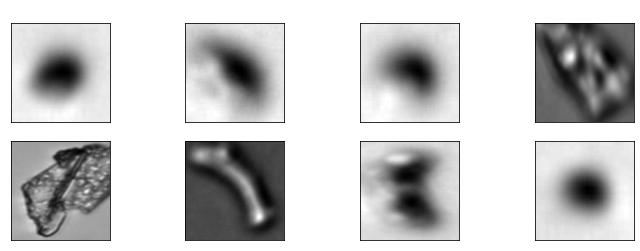

In [95]:
dataiter = iter(dataloader_train)
images, labels, xfeatures = dataiter.next()
class_names = ['camp', 'grim', 'pollen', 'dust']

fig = plt.figure(figsize=(12, 4))
# display 20 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, int(8/2), idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx,0,:,:], cmap='gray')
    ax.set_title(class_names[int(labels.numpy()[idx])], color='w')


In [96]:
class CNN_BOTH(nn.Module):
    def __init__(self, pretrained=True):
        
        super().__init__()

        self.base = models.resnet18(pretrained=pretrained) # the CNN is based on pretrained ResNet18        
            
        n_features = self.base.fc.in_features #512
        
        self.base.fc = nn.Linear(n_features, 64)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
        self.meta_net = nn.Sequential(nn.Linear(34, 128),
                                      nn.BatchNorm1d(128),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.5),
                                      nn.Linear(128, 64),
                                      nn.BatchNorm1d(64),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.5),
                                      nn.Linear(64, 32)
                                     )        
        
        self.fc3 = nn.Linear(96, 40)
        self.bn3 = nn.BatchNorm1d(40)
        
        self.layer_out = nn.Linear(40, 1) 
        self.sigmoid = nn.Sigmoid()


    def forward(self, imgs, metas):
        cnn1 = self.base(imgs)
        x = self.bn1(cnn1)
        x = self.relu(x)
        x = self.dropout(x)
        
        meta_ = self.meta_net(metas)
        
        x = torch.cat((x, meta_), 1)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        x = self.sigmoid(x)
        return x

model_both = CNN_BOTH(pretrained=True)      

In [97]:
optimizer_both = AdamW(model_both.parameters(), lr=9e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

In [104]:
images, labels, xfeatures = dataiter

In [115]:
# define training function

def train_model(model, n_epochs, show_progress=bool):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    criterion = nn.BCELoss()

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        train_acc = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for step, (images, labels, xfeatures) in enumerate(dataloader_train):
            images = images
            xfeatures = xfeatures
            labels = labels

            # get output from model and track loss

            if model == model_both:
                optimizer_both.zero_grad()
                outputs = torch.reshape(model(images, xfeatures), (-1,))
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer_both.step()

            train_loss += loss.item()

            # update running training accuracy
            pred_class = torch.round(outputs)
            train_acc += (torch.sum(torch.eq(pred_class, labels))/images.size(0)).cpu().numpy()

    
        # monitor validation loss
        val_loss = 0.0
        val_acc = 0.0

        ######################
        # validate the model #
        ######################
        model.eval()
        for step, (images, labels, xfeatures) in enumerate(dataloader_val):
            images = images
            xfeatures = xfeatures
            labels = labels

            if model == model_img:
                outputs = torch.reshape(model(images), (-1,))
            if model == model_meta:
                outputs = torch.reshape(model(xfeatures), (-1,))
            if model == model_both:
                outputs = torch.reshape(model(images, xfeatures), (-1,))

            # update running training loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # update running training accuracy
            pred_class = torch.round(outputs)
            val_acc += (torch.sum(torch.eq(pred_class, labels))/images.size(0)).cpu().numpy()

        # print avg training and validation statistics 
        train_loss = train_loss
        train_acc = train_acc/len(dataloader_train)   
        val_loss = val_loss
        val_acc = val_acc/len(dataloader_val)
 
  

        # store avg training and validation statistics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if show_progress:
            print(f'-'*10)
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}, \tTraining Accuracy: {train_acc:.6f} \n\t\tValidation Loss: {val_loss:.6f}, \tValidation Accuracy: {val_acc:.6f}')

    return train_losses, train_accs, val_losses, val_accs

In [116]:
n_epochs = 25 #100
show_progress = True
train_losses_both, train_accs_both, val_losses_both, val_accs_both = train_model(model_both, n_epochs, show_progress = show_progress)

NameError: ignored

In [ ]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [ ]:
x_train.shape

(10000, 128, 128)

In [ ]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_10 (Dense)            (None, 64)                3936320   
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 dense_11 (Dense)            (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 10s 34ms/step - loss: 0.0356 - val_loss: 0.0124
Epoch 2/200
282/282 [==============================] - 10s 34ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 3/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 4/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 5/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 8/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0

In [ ]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [ ]:
y_preds = encoder.predict(x_train)

In [ ]:
map = umap.UMAP(n_components=2)
y = map.fit_transform(y_preds)

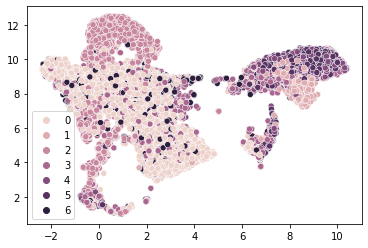

In [ ]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [ ]:
input_length = len(x_train_feats[0]) + latent_dim

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

dense_model = keras.Model(dense_input, dense_output, name='dense_model')

dense_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

dense_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_12 (Dense)            (None, 128)               12672     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  dense_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 3s 6ms/step - loss: 0.9731 - accuracy: 0.6734 - val_loss: 0.6064 - val_accuracy: 0.7940
Epoch 2/200
282/282 [==============================] - 1s 5ms/step - loss: 0.6959 - accuracy: 0.7560 - val_loss: 0.5610 - val_accuracy: 0.8020
Epoch 3/200
282/282 [==============================] - 1s 5ms/step - loss: 0.6391 - accuracy: 0.7696 - val_loss: 0.5465 - val_accuracy: 0.8020
Epoch 4/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5712 - accuracy: 0.7940 - val_loss: 0.5451 - val_accuracy: 0.8100
Epoch 5/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5629 - accuracy: 0.7934 - val_loss: 0.5207 - val_accuracy: 0.8130
Epoch 6/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5323 - accuracy: 0.8068 - val_loss: 0.5136 - val_accuracy: 0.8130
Epoch 7/200
282/282 [==============================] - 1s 5ms/step - loss: 0.5180 - accuracy: 0.8109 - val_loss: 0.5099 - val_accuracy: 0.8160

In [ ]:
dense_model.save('dense_model')

INFO:tensorflow:Assets written to: dense_model/assets


In [ ]:
tree = lgb.LGBMClassifier(objective='multiclass')

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
y_pred = tree.predict(x_train_with_encoded)

In [ ]:
sum(y_pred==x_train_lab)/len(y_pred)

0.8694